# [Code] Impact of COVID Misinformation on Vaccination Intent - A Reanalysis Identifying and Addressing Covariate Imbalances

Stanford Stats 209 Project

Authors: Zhongren Chen, Matheus Dias, Quentin Hsu

Full Report: https://www.overleaf.com/read/trngjhvnckrk

Covariate Names JSON Mapping: https://codebeautify.org/jsonviewer/cb92c22d

# Import Data

In [ ]:
# Download Relevant Files
system("gdown --id 1nWhtsofuJjDDm-qaiKVH0GvtEmmfGLC7") # full_orb_us.csv
system("gdown --id 1Zl1bHYKnZVCSKC3_e6-GXKk7Epzeukj8") # full_orb_uk.csv|
system("gdown --id 17Ta02ItPh5goVHnxZJku1H3Hh-sH8L-P") # utility.R

In [ ]:
# Install Packages
if(!require(tidytext)){
  install.packages("tidytext")
}
if(!require(optmatch)){
  install.packages("optmatch")
}
if(!require(DOS2)){
  install.packages("DOS2")
}
if(!require(RItools)){
  install.packages("RItools")
}
if(!require(gridExtra)){
  install.packages("gridExtra")
}
if(!require(estimatr)){
  install.packages("estimatr")
}
if(!require(ggpubr)){
  install.packages("ggpubr")
}
if(!require(rstatix)){
  install.packages("rstatix")
}
if(!require(pROC)){
  install.packages("pROC")
}

Loading required package: tidytext

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tidytext’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SnowballC’, ‘hunspell’, ‘janeaustenr’, ‘tokenizers’


Loading required package: optmatch

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘optmatch’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘abind’, ‘xtable’, ‘svd’, ‘minqa’, ‘numDeriv’, ‘mitools’, ‘RItools’, ‘survey’


Loading required package: DOS2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘DOS2’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also insta

In [ ]:
library(tidyverse)
library(tidytext)
library(optmatch)
library(DOS2)
library(RItools)
library(gridExtra)
library(estimatr)
library(ggpubr)
library(rstatix)
library(pROC)
source('utility.R')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks rstatix::filter(), stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: survival

The optmatch package has an academic license. Enter relaxinfo() for more information.


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [ ]:
df_us <- read.csv("full_orb_us.csv")

In [ ]:
head(df_us)

,X,Know.anyone.Nobody,Know.anyone.Myself,Know.anyone.Family.inside.HH,Know.anyone.Family.outside.HH,Know.anyone.Close.friend,Know.anyone.Colleague,COVID.19.Knowledge.Washing.hands,COVID.19.Knowledge.Staying.indoors.for.Self,COVID.19.Knowledge.Staying.indoors.for.Others,⋯,Age,Gender,Education,Employment,Religion,Political,Ethnicity,Income,Region,Treatment
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
1,0,0,0,0,0,0,1,1,2,2,⋯,3,1,5,1,1,3,1,5,11,1
2,1,1,0,0,0,0,0,2,2,2,⋯,5,2,2,1,5,2,1,1,18,1
3,2,0,0,0,0,0,1,2,1,1,⋯,5,2,4,1,1,3,1,3,1,1
4,3,0,1,0,0,0,0,2,-2,-1,⋯,1,2,3,1,5,3,3,2,11,1
5,4,1,0,0,0,0,0,1,1,-1,⋯,4,1,4,1,5,3,1,5,47,1
6,5,1,0,0,0,0,0,1,-2,-2,⋯,5,1,4,1,1,3,1,2,10,1


In [ ]:
# see https://github.com/sloomba/covid19-misinfo/blob/main/dat/orb_us.json for coding of the survey questions. Throw into a json viewer like http://jsonviewer.stack.hu/
str(df_us)

'data.frame':	4001 obs. of  137 variables:
 $ X                                                : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Know.anyone.Nobody                               : int  0 1 0 0 1 1 1 0 1 0 ...
 $ Know.anyone.Myself                               : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Know.anyone.Family.inside.HH                     : int  0 0 0 0 0 0 0 1 0 0 ...
 $ Know.anyone.Family.outside.HH                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Know.anyone.Close.friend                         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Know.anyone.Colleague                            : int  1 0 1 0 0 0 0 0 0 1 ...
 $ COVID.19.Knowledge.Washing.hands                 : int  1 2 2 2 1 1 2 1 2 2 ...
 $ COVID.19.Knowledge.Staying.indoors.for.Self      : int  2 2 1 -2 1 -2 2 2 2 2 ...
 $ COVID.19.Knowledge.Staying.indoors.for.Others    : int  2 2 1 -1 -1 -2 2 -1 2 -1 ...
 $ COVID.19.Knowledge.Spread.before.symptoms        : int  -1 2 2 -1 1 1 -1 1 2 2 ...
 $ COVID.19.Knowledge.R.Number    

# Data Processing

In [ ]:
# US
df_us_cleaned <- df_us %>%
  mutate(
    z = Treatment,
    inv_z = 1 - Treatment,

    # Pre-Treatment Covariates
    Shielding = ifelse(Shielding == 2, 0, 1),
    know.anyone.covid = (1 - Know.anyone.Nobody),

    # Derived Personas

    ## Bad Covid Knowledge
    ## only including these 5 which should be broadly known. Other 2 may not be well known.
    covid_knowledge_avg = (
      (COVID.19.Knowledge.Washing.hands) +
      (COVID.19.Knowledge.Staying.indoors.for.Self) +
      (COVID.19.Knowledge.Staying.indoors.for.Others) +
      (COVID.19.Knowledge.Spread.before.symptoms) +
      (COVID.19.Knowledge.Wearing.masks)
    )/5,
    bad_covid_knowledge = ifelse(covid_knowledge_avg < 0, 1, 0),
    
    ## Distrust of Covid Vax
    ## flip these two since their wording is opposite (agree is bad)
    COVID.19.VCI.COVID.19.Vax.Compatibility = COVID.19.VCI.COVID.19.Vax.Compatibility * -1,
    COVID.19.VCI.Contract.via.COVID.19.Vax = COVID.19.VCI.Contract.via.COVID.19.Vax *
      -1,
    covid_vax_trust_avg = (
      COVID.19.VCI.COVID.19.Vax.Importance +
        COVID.19.VCI.COVID.19.Vax.Safety +
        COVID.19.VCI.COVID.19.Vax.Efficacy +
        COVID.19.VCI.COVID.19.Vax.benefits.outweigh.risks +
        COVID.19.VCI.COVID.19.Vax.Compatibility +
        COVID.19.VCI.Contract.via.COVID.19.Vax
    ) / 6,
    bad_covid_vax_trust = ifelse(covid_vax_trust_avg < 0, 1, 0),
    
    ## Distrust of General Vax
    general_vax_trust_avg = (
      General.VCI.Vax.Importance +
        General.VCI.Vax.Safety +
        General.VCI.Vax.Efficacy +
        General.VCI.Vax.Compatibility
    ) / 4,
    bad_general_vax_trust = ifelse(general_vax_trust_avg < 0, 1, 0), 

    # note this is post-treatment, but should technically be ok
    # since should not have been affected by treatment
    covid_disrupt = ifelse((
      COVID.19.Impact.Mental.health +
        COVID.19.Impact.Financial.stability +
        COVID.19.Impact.Daily.disruption +
        COVID.19.Impact.Social.disruption
    ) / 4 > 0,
    1,
    0
    ), 

    # Processed Questions
    ## Make questions -1, 0, 1 for more samples per bucket
    COVID.19.Knowledge.Washing.hands.tri = ifelse(COVID.19.Knowledge.Washing.hands == 0, 0, ifelse(COVID.19.Knowledge.Washing.hands < 0, -1, 1)),
    COVID.19.Knowledge.Staying.indoors.for.Self.tri = ifelse(COVID.19.Knowledge.Staying.indoors.for.Self == 0, 0, ifelse(COVID.19.Knowledge.Staying.indoors.for.Self < 0, -1, 1)),
    COVID.19.Knowledge.Staying.indoors.for.Others.tri = ifelse(COVID.19.Knowledge.Staying.indoors.for.Others == 0, 0, ifelse(COVID.19.Knowledge.Staying.indoors.for.Others < 0, -1, 1)),
    COVID.19.Knowledge.Spread.before.symptoms.tri = ifelse(COVID.19.Knowledge.Spread.before.symptoms == 0, 0, ifelse(COVID.19.Knowledge.Spread.before.symptoms < 0, -1, 1)),
    COVID.19.Knowledge.Wearing.masks.tri = ifelse(COVID.19.Knowledge.Wearing.masks == 0, 0, ifelse(COVID.19.Knowledge.Wearing.masks < 0, -1, 1)),
    COVID.19.VCI.COVID.19.Vax.Importance.tri = ifelse(COVID.19.VCI.COVID.19.Vax.Importance == 0, 0, ifelse(COVID.19.VCI.COVID.19.Vax.Importance < 0, -1, 1)),
    COVID.19.VCI.COVID.19.Vax.Safety.tri = ifelse(COVID.19.VCI.COVID.19.Vax.Safety == 0, 0, ifelse(COVID.19.VCI.COVID.19.Vax.Safety < 0, -1, 1)),
    COVID.19.VCI.COVID.19.Vax.Efficacy.tri = ifelse(COVID.19.VCI.COVID.19.Vax.Efficacy == 0, 0, ifelse(COVID.19.VCI.COVID.19.Vax.Efficacy < 0, -1, 1)),
    COVID.19.VCI.COVID.19.Vax.benefits.outweigh.risks.tri = ifelse(COVID.19.VCI.COVID.19.Vax.benefits.outweigh.risks == 0, 0, ifelse(COVID.19.VCI.COVID.19.Vax.benefits.outweigh.risks < 0, -1, 1)),
    COVID.19.VCI.COVID.19.Vax.Compatibility.tri = ifelse(COVID.19.VCI.COVID.19.Vax.Compatibility == 0, 0, ifelse(COVID.19.VCI.COVID.19.Vax.Compatibility < 0, -1, 1)),
    COVID.19.VCI.Contract.via.COVID.19.Vax.tri = ifelse(COVID.19.VCI.Contract.via.COVID.19.Vax == 0, 0, ifelse(COVID.19.VCI.Contract.via.COVID.19.Vax < 0, -1, 1)),
    General.VCI.Vax.Importance.tri = ifelse(General.VCI.Vax.Importance == 0, 0, ifelse(General.VCI.Vax.Importance < 0, -1, 1)),
    General.VCI.Vax.Safety.tri = ifelse(General.VCI.Vax.Safety == 0, 0, ifelse(General.VCI.Vax.Safety < 0, -1, 1)),
    General.VCI.Vax.Efficacy.tri = ifelse(General.VCI.Vax.Efficacy == 0, 0, ifelse(General.VCI.Vax.Efficacy < 0, -1, 1)),
    General.VCI.Vax.Compatibility.tri = ifelse(General.VCI.Vax.Compatibility == 0, 0, ifelse(General.VCI.Vax.Compatibility < 0, -1, 1)),
    
    # Outcomes

    ## Strict Decrease in Vaccine Intent
    ## note that 1 is the first answer choice which is Yes, so a "decrease" in vaccine intent is actually an "increase" in the answer number choice
    Vaccine.Intent.for.self..Decrease = (Vaccine.Intent.for.self..Post. > Vaccine.Intent.for.self..Pre.),
    Vaccine.Intent.for.others..Decrease = (Vaccine.Intent.for.others..Post. > Vaccine.Intent.for.others..Pre.),

    pre_vaccine_no_intent = (Vaccine.Intent.for.self..Pre. == 4),
    
    ## Agreeing with Misinfo
    Image.NumAgree = ((Image.1.Agreement > 0) + (Image.2.Agreement > 0) + (Image.3.Agreement > 0) + (Image.4.Agreement > 0) + (Image.5.Agreement > 0)),
    Image.NumDontKnow = ((Image.1.Agreement == 0) + (Image.2.Agreement == 0) + (Image.3.Agreement == 0) + (Image.4.Agreement == 0) + (Image.5.Agreement == 0)),
    Image.NumDisagree = (5 - Image.NumAgree - Image.NumDontKnow),
    NumMisinfoBelief = Treatment*Image.NumAgree + (1-Treatment)*(Image.NumDisagree),
    MisinfoBeliever = NumMisinfoBelief > 1,

    ## Sharing the Misinfo
    Image.NumShare = ((Image.1.Share > 0) + (Image.2.Share> 0) + (Image.3.Share > 0) + (Image.4.Share > 0) + (Image.5.Share > 0)),
    Image.NumDontKnow = ((Image.1.Share == 0) + (Image.2.Share == 0) + (Image.3.Share == 0) + (Image.4.Share == 0) + (Image.5.Share == 0)),
    Image.NumNotShare = (5 - Image.NumShare - Image.NumDontKnow),
    NumMisinfoShare = Treatment*Image.NumShare + (1-Treatment)*(Image.NumNotShare),
    MisinfoShare = NumMisinfoShare > 1,
    
    ## Trusting the Misinfo Source
    Image.NumTrust = ((Image.1.Trust > 0) + (Image.2.Trust> 0) + (Image.3.Trust > 0) + (Image.4.Trust > 0) + (Image.5.Trust > 0)),
    Image.NumDontKnow = ((Image.1.Trust == 0) + (Image.2.Trust == 0) + (Image.3.Trust == 0) + (Image.4.Trust == 0) + (Image.5.Trust == 0)),
    Image.NumNotTrust = (5 - Image.NumTrust - Image.NumDontKnow),
    NumMisinfoTrust = Treatment*Image.NumTrust + (1-Treatment)*(Image.NumNotTrust),
    MisinfoTrust = NumMisinfoTrust > 1
  )

df_us_cleaned %>%
  select(
    z,
    inv_z,
    Treatment,
    Shielding,
    know.anyone.covid,
    bad_covid_knowledge,
    bad_covid_vax_trust,
    bad_general_vax_trust,
    covid_disrupt,
    Vaccine.Intent.for.self..Decrease,
    Vaccine.Intent.for.self..Post.,
    Vaccine.Intent.for.self..Pre.,
    Vaccine.Intent.for.others..Decrease,
    Vaccine.Intent.for.others..Post.,
    Vaccine.Intent.for.others..Pre.,
    NumMisinfoBelief,
    NumMisinfoShare,
    NumMisinfoTrust
  ) %>% head()

,z,inv_z,Treatment,Shielding,know.anyone.covid,bad_covid_knowledge,bad_covid_vax_trust,bad_general_vax_trust,covid_disrupt,Vaccine.Intent.for.self..Decrease,Vaccine.Intent.for.self..Post.,Vaccine.Intent.for.self..Pre.,Vaccine.Intent.for.others..Decrease,Vaccine.Intent.for.others..Post.,Vaccine.Intent.for.others..Pre.,NumMisinfoBelief,NumMisinfoShare,NumMisinfoTrust
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<int>,<lgl>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,0,1,0,1,0,0,0,0,TRUE,2,1,FALSE,1,1,3,3,1
2,1,0,1,1,0,0,0,0,1,FALSE,1,1,FALSE,1,1,5,5,5
3,1,0,1,1,1,0,0,0,1,FALSE,3,3,TRUE,3,1,2,1,0
4,1,0,1,0,1,1,0,1,0,FALSE,2,2,FALSE,1,1,1,2,1
5,1,0,1,0,0,0,0,0,0,FALSE,2,2,FALSE,1,1,0,0,0
6,1,0,1,1,0,1,1,1,1,FALSE,4,4,FALSE,4,4,1,1,1


In [ ]:
df_us_cleaned_removed_no_intent <- df_us_cleaned %>%
  filter(pre_vaccine_no_intent == 0)

In [ ]:
final_covariates <- c(
  'Age',
  'Gender', 
  'Education', 
  'Employment', 
  'Religion', 
  'Political', 
  'Ethnicity', 
  'Income',
  'know.anyone.covid',
  'Shielding',
  'bad_covid_knowledge',
  'bad_covid_vax_trust',
  'bad_general_vax_trust',
  'covid_disrupt'
)

detailed_covariates <- c(
  final_covariates,
  'COVID.19.Knowledge.Washing.hands.tri',
  'COVID.19.Knowledge.Staying.indoors.for.Self.tri',
  'COVID.19.Knowledge.Staying.indoors.for.Others.tri',
  'COVID.19.Knowledge.Spread.before.symptoms.tri',
  'COVID.19.Knowledge.Wearing.masks.tri',
  'COVID.19.VCI.COVID.19.Vax.Importance.tri',
  'COVID.19.VCI.COVID.19.Vax.Safety.tri',
  'COVID.19.VCI.COVID.19.Vax.Efficacy.tri',
  'COVID.19.VCI.COVID.19.Vax.benefits.outweigh.risks.tri',
  'COVID.19.VCI.COVID.19.Vax.Compatibility.tri',
  'COVID.19.VCI.Contract.via.COVID.19.Vax.tri',
  'General.VCI.Vax.Importance.tri',
  'General.VCI.Vax.Safety.tri',
  'General.VCI.Vax.Efficacy.tri',
  'General.VCI.Vax.Compatibility.tri'
)

In [ ]:
summary(df_us_cleaned)

       X        Know.anyone.Nobody Know.anyone.Myself
 Min.   :   0   Min.   :0.0000     Min.   :0.00000   
 1st Qu.:1000   1st Qu.:0.0000     1st Qu.:0.00000   
 Median :2000   Median :1.0000     Median :0.00000   
 Mean   :2035   Mean   :0.5414     Mean   :0.07298   
 3rd Qu.:3001   3rd Qu.:1.0000     3rd Qu.:0.00000   
 Max.   :4995   Max.   :1.0000     Max.   :1.00000   
                                                     
 Know.anyone.Family.inside.HH Know.anyone.Family.outside.HH
 Min.   :0.00000              Min.   :0.0000               
 1st Qu.:0.00000              1st Qu.:0.0000               
 Median :0.00000              Median :0.0000               
 Mean   :0.06423              Mean   :0.1437               
 3rd Qu.:0.00000              3rd Qu.:0.0000               
 Max.   :1.00000              Max.   :1.0000               
                                                           
 Know.anyone.Close.friend Know.anyone.Colleague
 Min.   :0.000            Min.   :0.0000

# Imbalance

## Mahalanobis Distance FRT

In [ ]:
computeMahalanobis <- function(treatment.data, control.data) {
  total.data <- rbind(treatment.data, control.data)
  mean.treatment <- as.vector(colMeans(treatment.data))
  mean.control <- as.vector(colMeans(control.data))
  result <- mahalanobis(mean.treatment, mean.control, cov = cov(total.data))
  
  return(result)
}

simulate <- function(data) {
  # Build Random Vector
  data$random <- sample(data$z, replace=F, size=nrow(data))
  
  # Filter dataframes
  treatment_data = filter(data, random == 1)
  control_data = filter(data, random == 0)
  
  # Only select the relevant covariates
  treatment_data = treatment_data[, final_covariates]
  control_data = control_data[, final_covariates]
  
  distance <- computeMahalanobis(treatment_data, control_data)
  
  return(distance)
}

overall_mahal_sim <- c()

for(i in 1:10000) {
  overall_mahal_sim[i] <- simulate(df_us_cleaned)
}

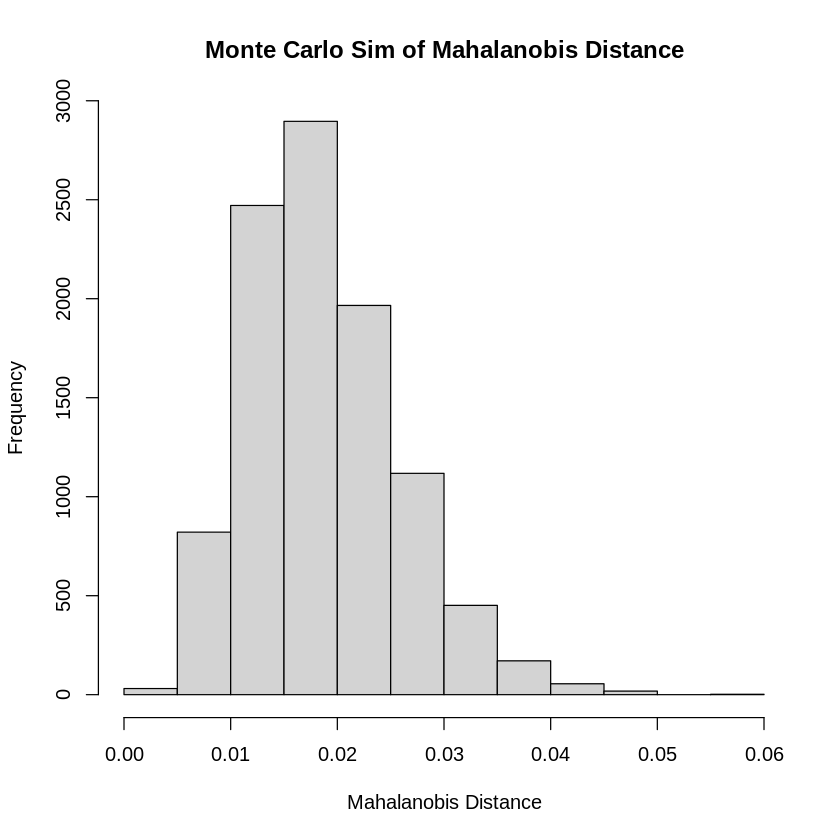

In [ ]:
orig_study_mahal <-
  computeMahalanobis(filter(df_us_cleaned, z == 1)[, final_covariates], filter(df_us_cleaned, z == 0)[, final_covariates])
mahal_p_val <- mean(overall_mahal_sim > orig_study_mahal)

hist(overall_mahal_sim,
     main = 'Monte Carlo Sim of Mahalanobis Distance',
     xlab = 'Mahalanobis Distance')
abline(v = orig_study_mahal, lty = 2)

In [ ]:
orig_study_mahal
mahal_p_val

[1] 0.4159985

[1] 0

## Visualizing the Imbalance

### Propensity Score

In [ ]:
df_us_cleaned$prop2  <-
  glm(as.formula(paste("z ~", paste(
    final_covariates, collapse = " + "
  ))),
  family = binomial(link = "logit"),
  data = df_us_cleaned)$fitted.values

auc(df_us_cleaned$z, df_us_cleaned$prop2)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.687

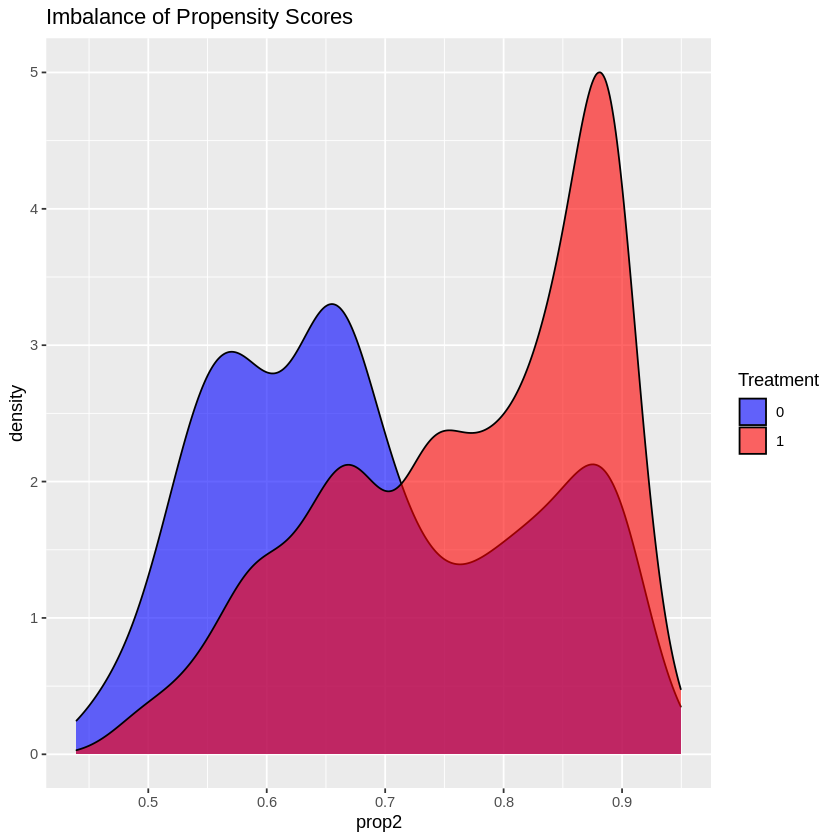

In [ ]:
df_us_cleaned %>%
  mutate(Treatment = as.factor(Treatment)) %>% 
  ggplot(aes(x = prop2, fill = Treatment)) +
  geom_density(alpha=0.6) +
  scale_fill_manual(values = c("blue","red")) +
  ggtitle('Imbalance of Propensity Scores')

### Matching Plots

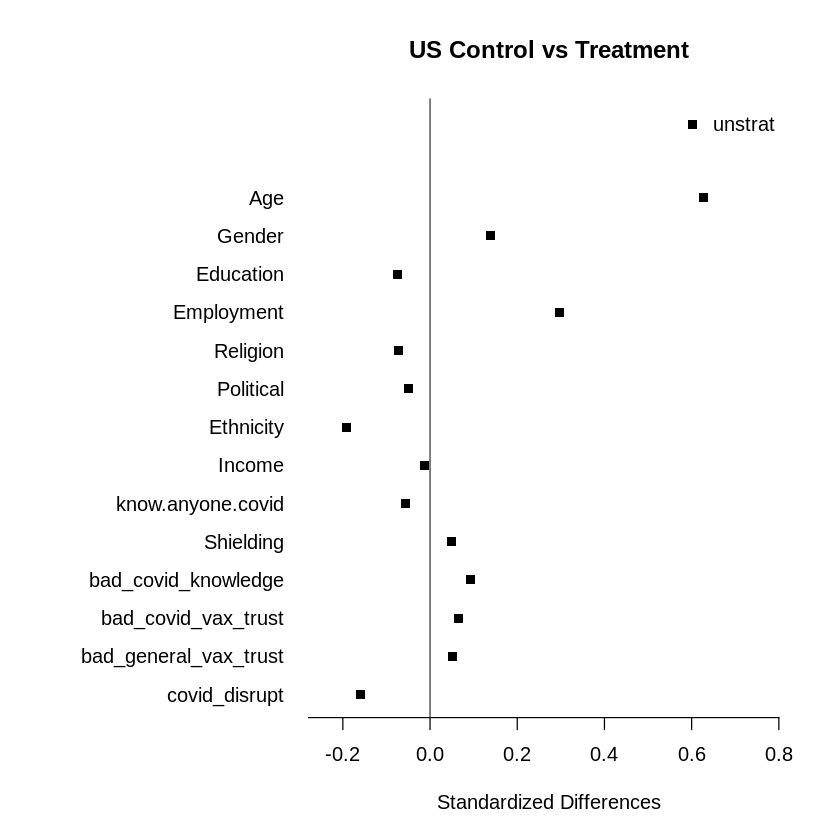

In [ ]:
plot(
  xBalance(
    as.formula(paste("Treatment ~", paste(final_covariates, collapse = " + "))),
    data = df_us_cleaned
  ),
  main="US Control vs Treatment"
)

## Individual Covariate T-Tests

In [ ]:
df_us_cleaned.long <-
  select_if(df_us_cleaned[, c('z', final_covariates)], is.numeric)   %>%
  pivot_longer(-z, names_to = "variables", values_to = "value")

stat.test <- df_us_cleaned.long %>%
  group_by(variables) %>%
  t_test(value ~ z) %>%
  adjust_pvalue(method = "bonferroni") %>%
  add_significance()

stat.test[, c('variables', 'statistic', 'p.adj', 'p.adj.signif')] %>% 
  arrange(p.adj)

variables,statistic,p.adj,p.adj.signif
<chr>,<dbl>,<dbl>,<chr>
Age,-17.2654778,1.3370e-60,****
Employment,-8.7647881,5.5300e-17,****
Ethnicity,4.9574744,1.1074e-05,****
covid_disrupt,4.4650867,1.1900e-04,***
Gender,-3.7735170,2.3240e-03,**
bad_covid_knowledge,-2.7140540,9.3940e-02,ns
Education,2.0158926,6.1600e-01,ns
Religion,1.9627419,6.9720e-01,ns
bad_covid_vax_trust,-1.8518380,8.9880e-01,ns


In [ ]:
imbalanced_covariates <- stat.test %>%
  filter(p.adj.signif != 'ns') %>%
  pull(variables)

## Impact of Imbalanced Covariates

In [ ]:
pre_intent_plot <- function(df, group, y, item = 'plot') {
  lower_limit <- ifelse(y == 'NumMisinfoBelief',-1.25,-0.5)
  upper_limit <- ifelse(y == 'NumMisinfoBelief', 3.25, 0.5)
  
  group = sym(group)
  y = sym(y)
  
  benchmark <- mean(df %>% pull(!!y))
  
  processed_df <- df %>%
    mutate(!!group := as.factor(!!group)) %>%
    group_by(!!group) %>%
    summarize(
      .groups = 'keep',
      t = mean(!!y),
      v = var(!!y) / n(),
      t_lower = t - 1.96 * sqrt(v),
      t_upper = t + 1.96 * sqrt(v)
    ) %>%
    select(!!group, t, v, t_lower, t_upper)
  
  se <- processed_df %>%
    ungroup() %>%
    summarize(se = sqrt(var(t))) %>%
    pull(se)
  
  p <- processed_df %>%
    ggplot(aes(
      x = t,
      y = !!group,
      group = !!group
    )) +
    #draws the means
    # geom_point(position = position_dodge(1)) +
    geom_point() +
    #draws the CI error bars
    geom_errorbarh(aes(xmin = t_lower, xmax = t_upper),
                   # color = !!group),
                   show.legend = FALSE,
                   height = 0) +
    # position = position_dodge(0.78)) +
    # xlim(lower_limit, upper_limit) +
    geom_vline(xintercept = benchmark, linetype = "dotted") +
    labs(
      title = group,
      x = 'avg pre vaccine intent') +
    theme(axis.title.y = element_blank())
  
  return(if (item == 'se') {
    se
  } else{
    p
  })
}

In [ ]:
pre_vaccine_intent_se <- data.frame(covariate = character(),
                                      se = double())
pre_vaccine_intent_plots <- list()

i = 1
for (c in detailed_covariates) {
  pre_vaccine_intent_se <- pre_vaccine_intent_se %>%
    add_row(
      covariate = c,
      se = pre_intent_plot(df_us_cleaned, c, 'Vaccine.Intent.for.self..Pre.', 'se')
    )
  pre_vaccine_intent_plots[[i]] <-
    pre_intent_plot(df_us_cleaned, c, 'Vaccine.Intent.for.self..Pre.', 'plot')
  i = i + 1
}

Imbalanced Covariates

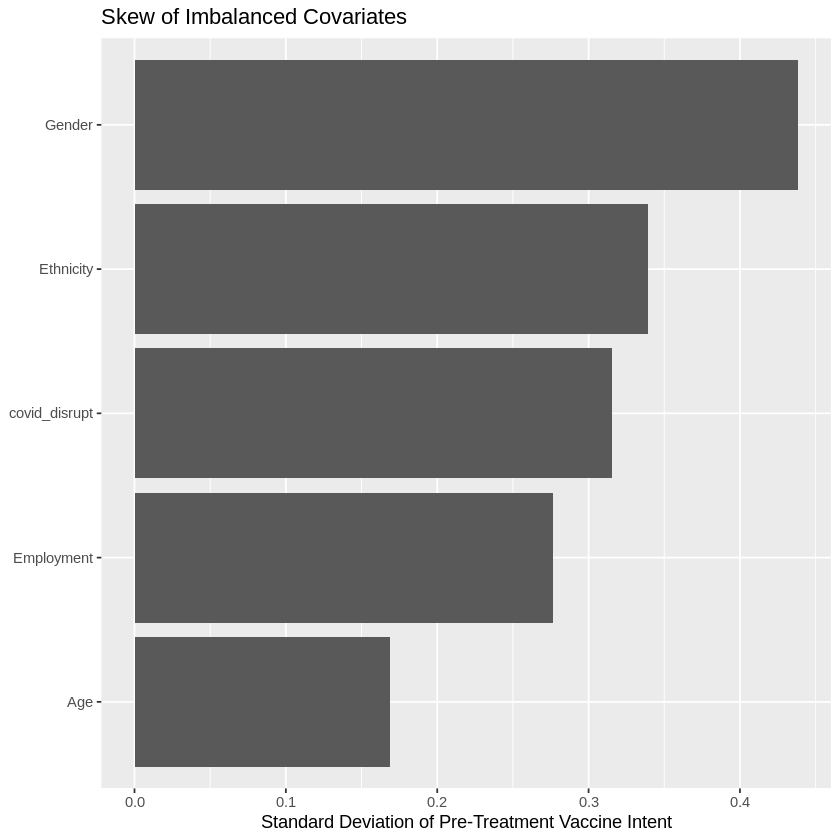

In [ ]:
pre_vaccine_intent_se %>% 
  filter(covariate %in% imbalanced_covariates) %>% 
  ggplot(aes(x = reorder(covariate, se), y = se)) +
  geom_bar(stat = 'identity') +
  coord_flip() +
  theme(
    axis.title.y = element_blank()
  ) +
  labs(
    title='Skew of Imbalanced Covariates',
    y='Standard Deviation of Pre-Treatment Vaccine Intent'
  )
  

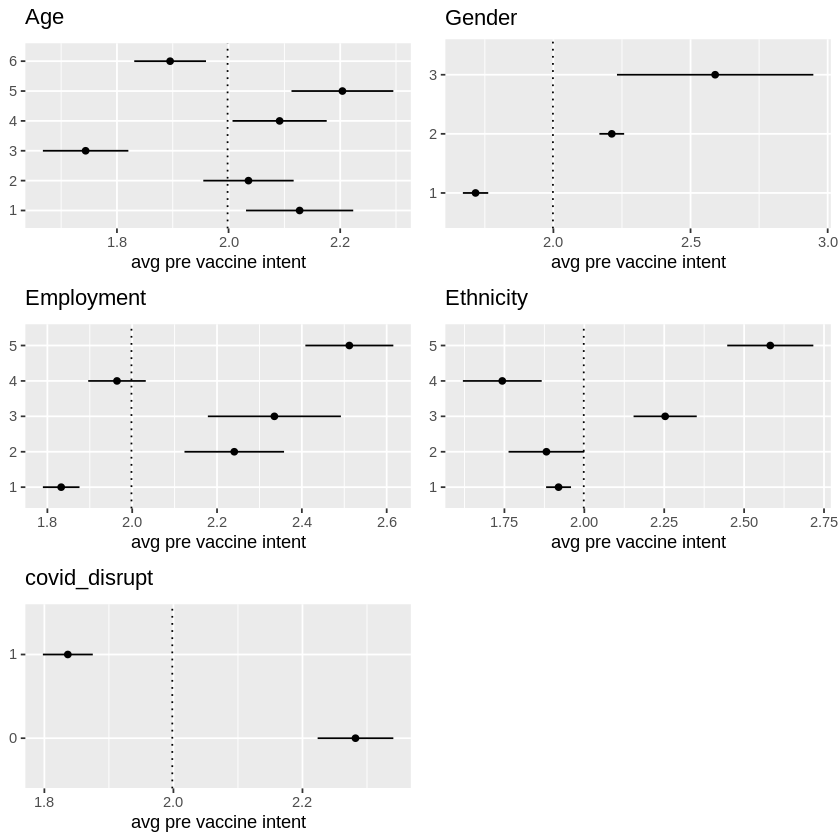

In [ ]:
grid.arrange(grobs = pre_vaccine_intent_plots[c(1,2,4,7,14)], ncol = 2)

All Explored Covariates

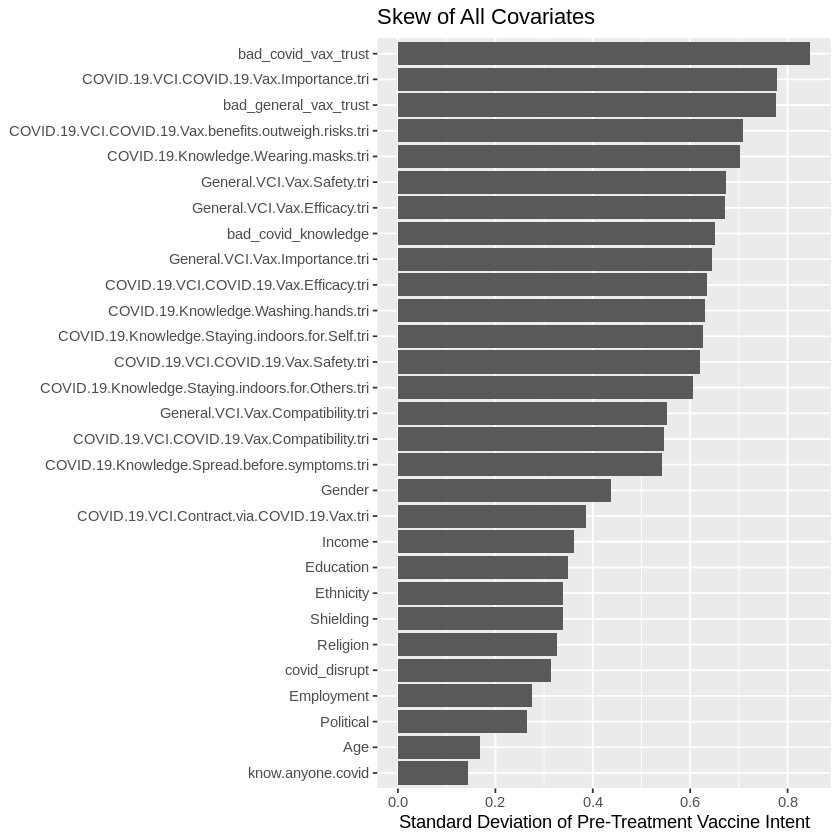

In [ ]:
pre_vaccine_intent_se %>% 
  ggplot(aes(x = reorder(covariate, se), y = se)) +
  geom_bar(stat = 'identity') +
  coord_flip() +
  theme(
    axis.title.y = element_blank()
  ) +
  labs(
    title='Skew of All Covariates',
    y='Standard Deviation of Pre-Treatment Vaccine Intent'
  )

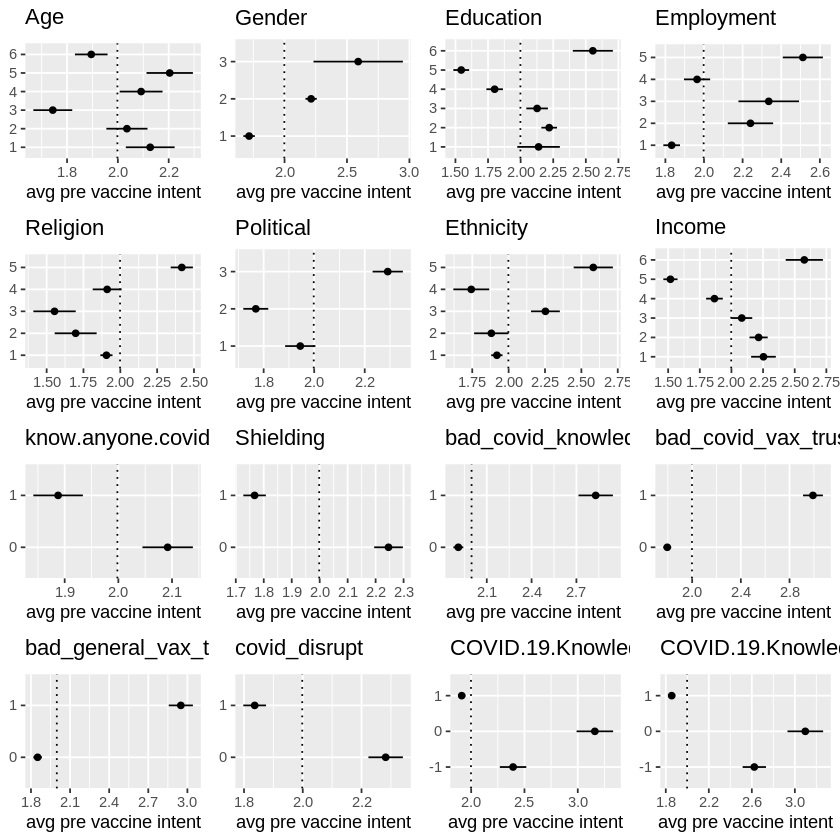

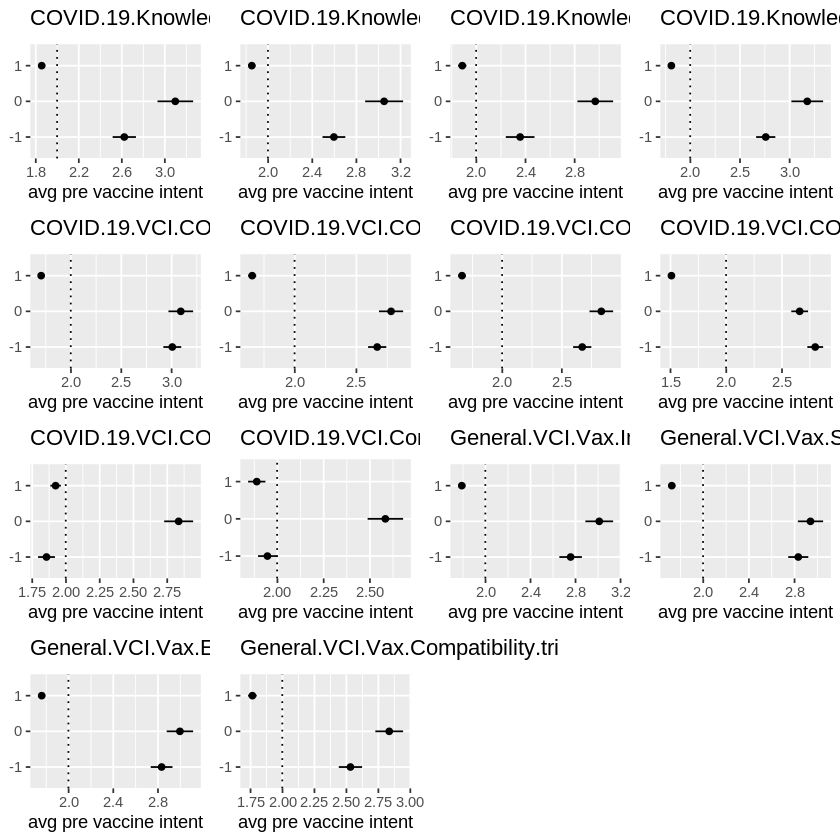

In [ ]:
grid.arrange(grobs = pre_vaccine_intent_plots[1:16], ncol = 4)
grid.arrange(grobs = pre_vaccine_intent_plots[16:length(pre_vaccine_intent_plots)], ncol = 4)

# Adjusting for Imbalance

## Setup 

In [ ]:
df_adj_summary <- data.frame(
  method = character(),
  outcome = character(),
  estimate = double(),
  std_err = double(),
  p_val = double()
)

In [ ]:
ttest <- function(df, method_name, Y, treatment, control, alternative = 'greater'){
   results <- t.test(
    treatment,
    control,
    alternative = alternative
  )

  df <- df %>% 
    add_row(
      method = method_name,
      outcome = Y,
      estimate = results$estimate[1] - results$estimate[2],
      std_err = results$stderr,
      p_val = results$p.value
    )
  return(df)
}

## Baseline

In [ ]:
# SELF US
df_adj_summary <- ttest(
  df_adj_summary,
  method_name = 'FRT',
  Y = 'Vaccine_Intent_Self',
  treatment = filter(df_us_cleaned_removed_no_intent, Treatment == 1)$Vaccine.Intent.for.self..Decrease,
  control = filter(df_us_cleaned_removed_no_intent, Treatment == 0)$Vaccine.Intent.for.self..Decrease,
  alternative = 'greater'
)
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.08659778,0.01302287,1.920301e-11


## Regression Adjustment

In [ ]:
#### Prepare Dataset for doing Lin's estimator in US
df_us_Lin <- df_us_cleaned_removed_no_intent %>%
  select(
    c(
    'z',
    'Vaccine.Intent.for.self..Decrease',
    all_of(final_covariates)
    )
  )

#### Centralize covariates
lin_covariates <-
  subset(df_us_Lin, select = -c(z, Vaccine.Intent.for.self..Decrease))

lin_covariates_sub_mean = lin_covariates - colMeans(lin_covariates)
lin_adj_us = lm_robust(
  df_us_Lin$Vaccine.Intent.for.self..Decrease ~ df_us_Lin$z + . +
    df_us_Lin$z * . ,
  lin_covariates_sub_mean
)

In [ ]:
df_adj_summary <- df_adj_summary %>% 
    add_row(
      method = 'Lins Estimator',
      outcome = 'Vaccine_Intent_Self',
      estimate = lin_adj_us$coefficients['df_us_Lin$z'],
      std_err = lin_adj_us$std.error['df_us_Lin$z'],
      p_val = lin_adj_us$p.value['df_us_Lin$z']
    )
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.08659778,0.01302287,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.07380057,0.03266724,2.393695e-02


## Matching

In [ ]:
matching_adj <- function(df, 
                         covariates, 
                         num_matches = 1, 
                         match_from = 'control' # flip the z if matching from treatment, eg more treatment than control
                         ){
  df$prop <-
    glm(
      as.formula(paste(ifelse(match_from == 'treatment', "inv_z ~", "z ~"), paste(covariates, collapse = " + "))),
      family = binomial,
      data = df
    )$fitted.values

  mahal <- smahal(
      if(match_from == 'treatment'){df$inv_z} else{df$z},
      df[, covariates])

  mahal.match <- pairmatch(mahal, control = num_matches, data = df)
  match_summary <-
    summarize.match(df, mahal.match)
  p <- xBalance(
        as.formula(paste(paste("Treatment ~", paste(covariates, collapse = " + ")), '+ strata(mahal.match) - 1')),
        data = df
      )

  return_items <- list("summary" = match_summary, "mahal_match" = mahal.match, "xBalance" = p)
  return(return_items)
}

match_results <- matching_adj(df_us_cleaned_removed_no_intent, final_covariates, num_matches = 2, match_from = 'treatment')

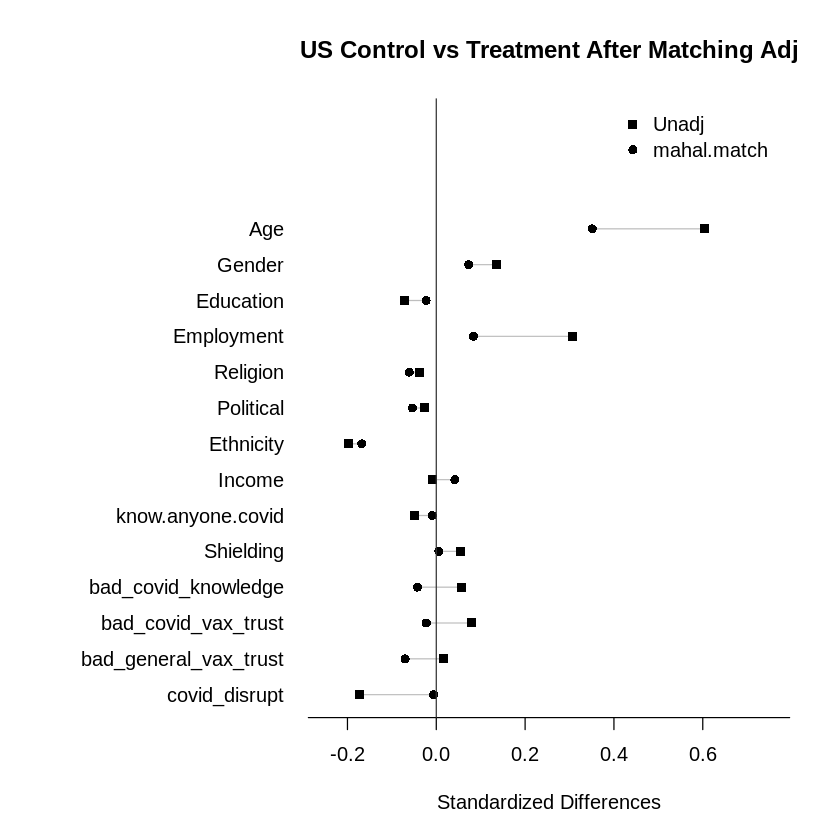

In [ ]:
plot(match_results$xBalance,
  main="US Control vs Treatment After Matching Adj")

In [ ]:
df_adj_summary <- ttest(
  df_adj_summary,
  method_name = 'matching',
  Y = 'Vaccine_Intent_Self',
  treatment = match_results$summary$Vaccine.Intent.for.self..Decrease.1,
  control = match_results$summary$Vaccine.Intent.for.self..Decrease.0,
  alternative = 'greater'
)
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.08659778,0.01302287,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.07380057,0.03266724,2.393695e-02
matching,Vaccine_Intent_Self,0.07943925,0.01191567,1.530347e-11


## Placebo Benchmark

In [ ]:
# train glm on the covariates (not depending on treatment at all)
glm_ber <- glm(as.formula(paste(
  "Vaccine.Intent.for.self..Decrease ~",
  paste(final_covariates, collapse = " + ")
)),
family = binomial,
data = df_us_cleaned)

# use trained glm to predict placebo Y's for full dataset
df_us_cleaned$placebo_y_prob <-
  predict(glm_ber, df_us_cleaned[, final_covariates], type = "response")

Baseline

In [ ]:
df_adj_summary <- ttest(
  df_adj_summary,
  method_name = 'FRT',
  Y = 'Placebo_Y',
  treatment = filter(df_us_cleaned, Treatment == 1)$placebo_y_prob,
  control = filter(df_us_cleaned, Treatment == 0)$placebo_y_prob,
  alternative = 'two.sided'
)
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.086597782,0.013022871,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.073800570,0.032667238,2.393695e-02
matching,Vaccine_Intent_Self,0.079439252,0.011915672,1.530347e-11
FRT,Placebo_Y,0.002514752,0.001380498,6.869553e-02


Lin's Estimator

In [ ]:
placebo_lin_covariates <- df_us_cleaned[,final_covariates] - colMeans(df_us_cleaned[,final_covariates]) 

placebo_lin_fit <- lm_robust(df_us_cleaned$placebo_y_prob ~ df_us_cleaned$z + . + 
          df_us_cleaned$z * . , placebo_lin_covariates)

df_adj_summary <- df_adj_summary %>% 
    add_row(
      method = 'Lins Estimator',
      outcome = 'Placebo_Y',
      estimate = placebo_lin_fit$coefficients['df_us_cleaned$z'],
      std_err = placebo_lin_fit$std.error['df_us_cleaned$z'],
      p_val = placebo_lin_fit$p.value['df_us_cleaned$z']
    )
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.086597782,0.013022871,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.073800570,0.032667238,2.393695e-02
matching,Vaccine_Intent_Self,0.079439252,0.011915672,1.530347e-11
FRT,Placebo_Y,0.002514752,0.001380498,6.869553e-02
Lins Estimator,Placebo_Y,0.009313576,0.005651380,9.942806e-02


Matching

In [ ]:
match_results_placebo <- matching_adj(df_us_cleaned,
                              final_covariates,
                              num_matches = 2,
                              match_from = 'treatment')

df_adj_summary <- ttest(
  df_adj_summary,
  method_name = 'matching',
  Y = 'Placebo_Y',
  treatment = match_results_placebo$summary$placebo_y_prob.1,
  control = match_results_placebo$summary$placebo_y_prob.0,
  alternative = 'two.sided'
)
df_adj_summary

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.0865977820,0.013022871,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.0738005700,0.032667238,2.393695e-02
matching,Vaccine_Intent_Self,0.0794392523,0.011915672,1.530347e-11
FRT,Placebo_Y,0.0025147524,0.001380498,6.869553e-02
Lins Estimator,Placebo_Y,0.0093135764,0.005651380,9.942806e-02
matching,Placebo_Y,-0.0004977516,0.001179685,6.730946e-01


## Summary Results


In [ ]:
df_adj_summary %>%
  filter(outcome == 'Vaccine_Intent_Self')

method,outcome,estimate,std_err,p_val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
FRT,Vaccine_Intent_Self,0.0865977820,0.013022871,1.920301e-11
Lins Estimator,Vaccine_Intent_Self,0.0738005700,0.032667238,2.393695e-02
matching,Vaccine_Intent_Self,0.0794392523,0.011915672,1.530347e-11
FRT,Placebo_Y,0.0025147524,0.001380498,6.869553e-02
Lins Estimator,Placebo_Y,0.0093135764,0.005651380,9.942806e-02
matching,Placebo_Y,-0.0004977516,0.001179685,6.730946e-01


# Heterogenous Treatment Effects

In [ ]:
hte_plot <- function(df, group, y){
  lower_limit <- ifelse(y == 'NumMisinfoBelief', -1.25, -0.5)
  upper_limit <- ifelse(y == 'NumMisinfoBelief', 3.25, 0.5)
  
  group = sym(group)
  y = sym(y)
  
  p <- df %>% 
    mutate(
      !!group := as.factor(!!group)
    ) %>% 
    group_by(!!group, z) %>% 
    summarize(
      .groups = 'keep',
      t = mean(!!y),
      v = var(!!y) / n()
    ) %>%
    pivot_wider(names_from = z, values_from = c(t, v)) %>%
    mutate(
      T = t_1 - t_0,
      var = v_0 + v_1,
      T_lower = T - 1.96 *sqrt(var),
      T_upper = T + 1.96*sqrt(var)
    ) %>% 
    select(
      !!group, T, var, T_lower, T_upper
    ) %>%
    ggplot(aes(x=T, y = !!group, group = !!group)) +
    #draws the means
    # geom_point(position = position_dodge(1)) +
    geom_point() +
    #draws the CI error bars
    geom_errorbarh(
      aes(xmin = T_lower, xmax = T_upper),
          # color = !!group),
      show.legend = FALSE,
      height = 0
      # position = position_dodge(0.78)
    ) +
    xlim(lower_limit, upper_limit) +
    geom_vline(xintercept = 0, linetype="dotted") +
    ggtitle(group) +
    theme(axis.title.y=element_blank())
  
  return(p)
}

hte_plots_vaccine_intent_self <- list()
#hte_plots_vaccine_intent_others <- list()
#hte_plots_misinfo_belief <- list()

i = 1
for(c in detailed_covariates){
  hte_plots_vaccine_intent_self[[i]] <- (hte_plot(df_us_cleaned, c, 'Vaccine.Intent.for.self..Decrease'))
  #hte_plots_vaccine_intent_others[[i]] <- (hte_plot(df_us_cleaned, c, 'Vaccine.Intent.for.others..Decrease'))
  #hte_plots_misinfo_belief[[i]] <- (hte_plot(df_us_cleaned, c, 'NumMisinfoBelief'))
  i = i + 1
}

Warning message:
“Removed 1 rows containing missing values (geom_errorbarh).”


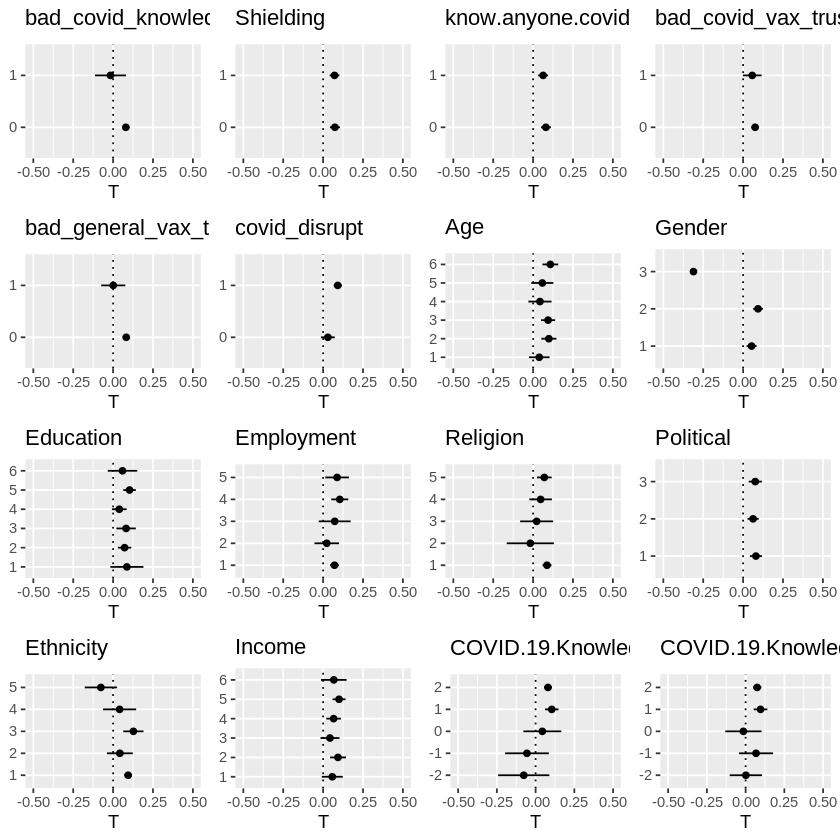

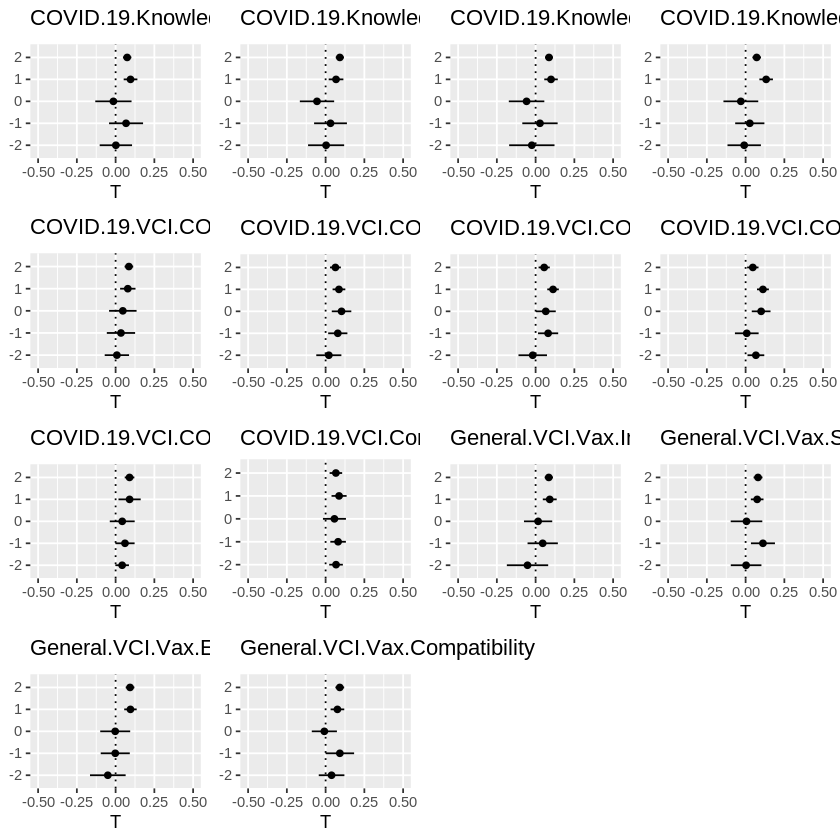

In [ ]:
grid.arrange(grobs = hte_plots_vaccine_intent_self[1:16], ncol = 4)
grid.arrange(grobs = hte_plots_vaccine_intent_self[16:length(hte_plots_vaccine_intent_self)], ncol = 4)

# Appendix

## Regression Adjustment for different Y

In [ ]:
### Prepare Dataset for doing Lin's estimator in US
df_us_Lin_diffY <- df_us %>%
  mutate(
    
    
    Image.NumAgree = ((Image.1.Agreement > 0) + (Image.2.Agreement > 0) + (Image.3.Agreement > 0) + (Image.4.Agreement > 0) + (Image.5.Agreement > 0)),
    Image.NumDontKnow = ((Image.1.Agreement == 0) + (Image.2.Agreement == 0) + (Image.3.Agreement == 0) + (Image.4.Agreement == 0) + (Image.5.Agreement == 0)),
    Image.NumDisagree = (5 - Image.NumAgree - Image.NumDontKnow),
    NumMisinfoBelief = Treatment*Image.NumAgree + (1-Treatment)*(Image.NumDisagree),
    MisinfoBeliever = NumMisinfoBelief > 1
  )

df_us_Lin_diffY <- df_us_Lin_diffY %>%
  select(
    Treatment,
    MisinfoBeliever,
    Age,
    Gender, 
    Education,
    Employment,
    Religion,
    Political,
    Ethnicity,
    Income   
  )

#### Centralize covariates
covariate <- subset(df_us_Lin_diffY, select=-c(Treatment, MisinfoBeliever))

covariate_sub_mean = covariate - colMeans(covariate) 
fit_misinfo_us = lm_robust(df_us_Lin_diffY$MisinfoBeliever ~ df_us_Lin_diffY$Treatment + . + 
          df_us_Lin_diffY$Treatment * . , covariate_sub_mean)

In [ ]:
fit_misinfo_us

                                          Estimate  Std. Error     t value
(Intercept)                           0.1740396861 0.019694216  8.83709626
df_us_Lin_diffY$Treatment             0.1450791027 0.024768026  5.85751572
Age                                   0.0019454845 0.006695294  0.29057493
Gender                                0.0048258691 0.013019011  0.37067863
Education                            -0.0070584299 0.007794243 -0.90559528
Employment                            0.0114954266 0.008324136  1.38097543
Religion                              0.0072905918 0.006165036  1.18257086
Political                             0.0002926068 0.010903823  0.02683525
Ethnicity                             0.0031752055 0.007980987  0.39784622
Income                               -0.0129332051 0.006720612 -1.92440894
df_us_Lin_diffY$Treatment:Age        -0.0611937418 0.008410222 -7.27611521
df_us_Lin_diffY$Treatment:Gender     -0.0592343925 0.016061044 -3.68807865
df_us_Lin_diffY$Treatment

## Old Placebo Code

Without covariate adjustment

In [ ]:
df_us_cleaned_control <- df_us_cleaned[df_us_cleaned$Treatment == 0,]
df_us_cleaned_treatment <- df_us_cleaned[df_us_cleaned$Treatment == 1,]
#### fit bernoulli glm on control:
glm_ber <- glm(Vaccine.Intent.for.self..Decrease ~ Age + Gender + Education + Employment + Religion
+ Political + Ethnicity + Income + know.anyone.covid + Shielding + bad_covid_knowledge + bad_covid_vax_trust
+ bad_general_vax_trust + covid_disrupt, 
       family=binomial(link=logit),
       data=df_us_cleaned_control)

prob_control <- predict(glm_ber, df_us_cleaned_control[,final_covariates], type = "response" )
fake_outcome_control <- rbernoulli(length(prob_control), p = prob_control)

prob_treatment <- predict(glm_ber, df_us_cleaned_treatment[,final_covariates], type = "response" )
fake_outcome_treatment <- rbernoulli(length(prob_treatment), p = prob_treatment)

#### Compute difference in mean:
mean(fake_outcome_control) - mean(fake_outcome_treatment)

[1] -0.003970343

With covariate adjustment

In [ ]:



# glm_ber_Lin <- glm(df_us_cleaned_control$Vaccine.Intent.for.self..Decrease ~ 
#        family=binomial(link=logit),
#        data=df_us_cleaned_control)

df_us_fake_outcome <- df_us_cleaned %>%
  mutate(
    placebo_Y <- c(fake_outcome_treatment, fake_outcome_control)
  )

Lin_covariate <- df_us_fake_outcome[,final_covariates] - colMeans(df_us_fake_outcome[,final_covariates]) 

placebo_lin_fit= lm(df_us_fake_outcome$placebo_Y ~ df_us_fake_outcome$Treatment + . + 
          df_us_Lin$Treatment * . , Lin_covariate)

summary(placebo_lin_fit)


Call:
lm(formula = df_us_fake_outcome$placebo_Y ~ df_us_fake_outcome$Treatment + 
    . + df_us_Lin$Treatment * ., data = Lin_covariate)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30619 -0.11244 -0.07175 -0.03353  1.04285 

Coefficients: (1 not defined because of singularities)
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                                0.139145   0.051116   2.722  0.00651
df_us_fake_outcome$Treatment               0.043335   0.058877   0.736  0.46176
Age                                        0.003360   0.005325   0.631  0.52809
Gender                                    -0.017464   0.010282  -1.698  0.08951
Education                                 -0.016347   0.005955  -2.745  0.00608
Employment                                 0.001925   0.005744   0.335  0.73748
Religion                                  -0.005611   0.004833  -1.161  0.24578
Political                                  0.009666   0.008553